In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from datetime import datetime

import tarfile
import gzip
import os
import xml.etree.ElementTree as ET

import pandas as pd
from data_preprocessing import * 
import json

import numpy as np
from sklearn.linear_model import LinearRegression
import load_functions as lf

# Load data

## Movie Summaries

In [19]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# add release year (float) to movie_metadata, extracting it from release_date
movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add lowecase title to movie_metadata
movie_metadata['lowercase_title'] = movie_metadata['movie_name'].str.lower()

# add release year (float) to character_metadata, extracting it from release_date
character_metadata['release_year'] = character_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add actor birth year (float) to character_metadata, extracting it from actor_birth_date
character_metadata['actor_birth_year'] = character_metadata['actor_birth_date'].apply(lambda x: lf.extract_year(x))

Metadata for 81 741 movies, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
10. Movie release year
11. Lowercase title

In [20]:
movie_metadata.head()

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,ghosts of mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,getting away with murder: the jonbenét ramsey ...
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,brun bitter
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,white of the eye
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,a woman in flames


Metadata for 450 669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
14. Release year
15. Actor birth year

In [21]:
character_metadata.head()

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,1977.0


Plot summaries of 42 303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie_metadata) followed by the summary.

In [22]:
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


# Basic features analysis

## Undestanding the dataset

In [23]:
print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())
print('\nnumber of rows in movie_metadata:',movie_metadata.shape[0])

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
release_year           6902
lowercase_title           0
dtype: int64

number of rows in movie_metadata: 81741


In [24]:
print('number of nan values in character_metadata:')
print(character_metadata.isna().sum())
print('\nnumber of character_metadata rows:', character_metadata.shape[0])

number of nan values in character_metadata:
wiki_movie_id                       0
free_movie_id                       0
release_date                     9995
character_name                 257875
actor_birth_date               106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
free_character_actor_map_id         0
free_character_id              257865
free_actor_id                     815
release_year                     9995
actor_birth_year               106156
dtype: int64

number of character_metadata rows: 450669


In [25]:
print('unique values of freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id'].unique()))
print('freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id']))
print('number of movie ID in character_metadata, which appear in movie_metadata:',
      sum(movie_metadata['free_movie_id'].isin(character_metadata['free_movie_id'].unique())))

unique values of freebase movie ID in character_metadata: 64330
freebase movie ID in character_metadata: 450669
number of movie ID in character_metadata, which appear in movie_metadata: 64330


Each movie in character_metadata appears in movie_metadata

In [26]:
print('unique values of freebase character ID in character_metadata (number of characters):',
      len(character_metadata['free_character_id'].unique()))
print('unique values of freebase actor ID in character_metadata (number of actors):',
      len(character_metadata['free_actor_id'].unique()))
print('unique values of actor ethnicity in character_metadata (number of ethnicities):',
      len(character_metadata['actor_ethnicity'].unique()))

unique values of freebase character ID in character_metadata (number of characters): 183436
unique values of freebase actor ID in character_metadata (number of actors): 135761
unique values of actor ethnicity in character_metadata (number of ethnicities): 480


## Plot data

### Movies metadata

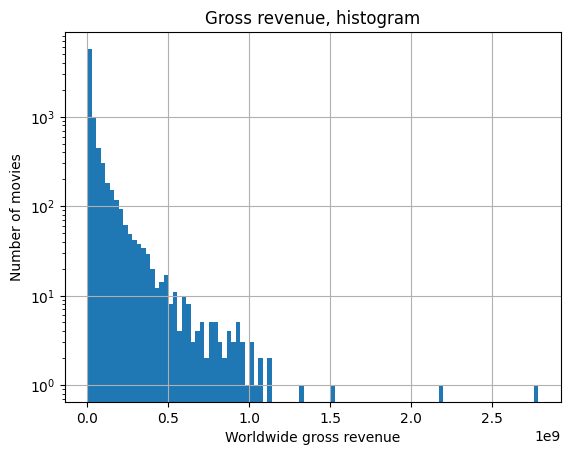

In [27]:
# gross revenue histogram
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

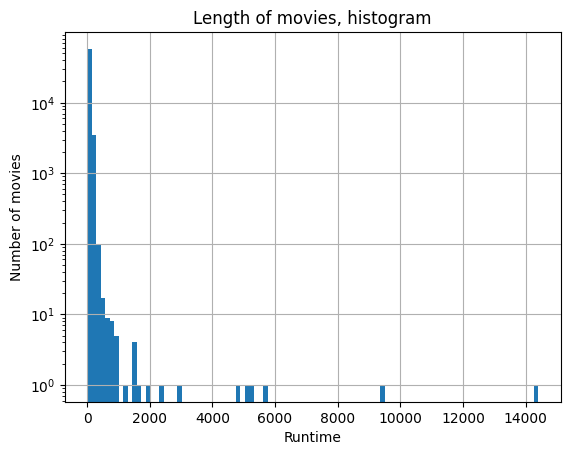

In [28]:
# length of movies histogram.
# We dropped movies with a length >= 1079280, as we observed errors in the dataset
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

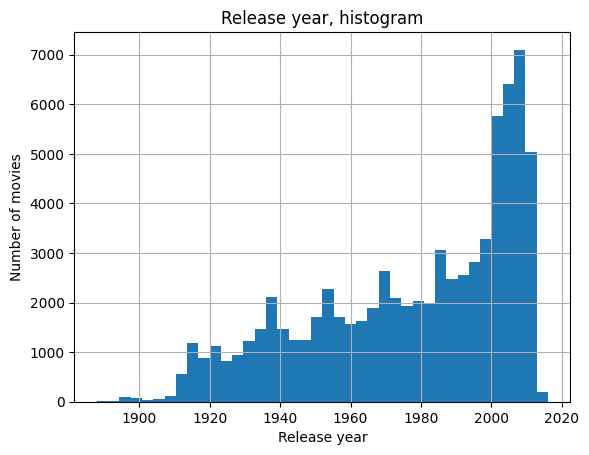

In [29]:
# release year histogram. We dropped movies with a release year <= 1011,
# We dropped movies with a release year <= 1011, as we observed errors in the dataset
movie_metadata[movie_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

### Characters metadata

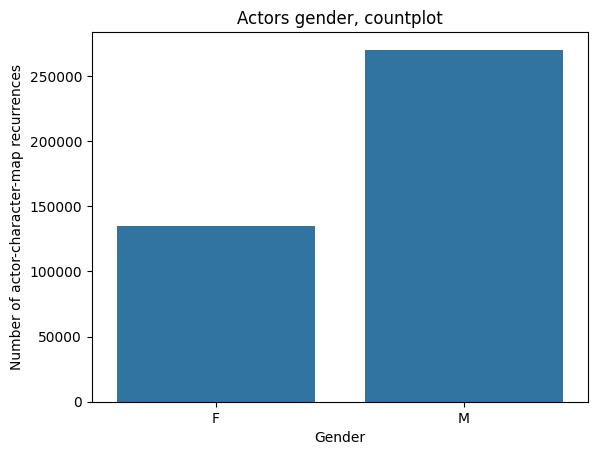

In [30]:
# actor gender countplot
sns.countplot(data=character_metadata, x="actor_gender");
plt.title('Actors gender, countplot')
plt.xlabel('Gender')
plt.ylabel('Number of actor-character-map recurrences');

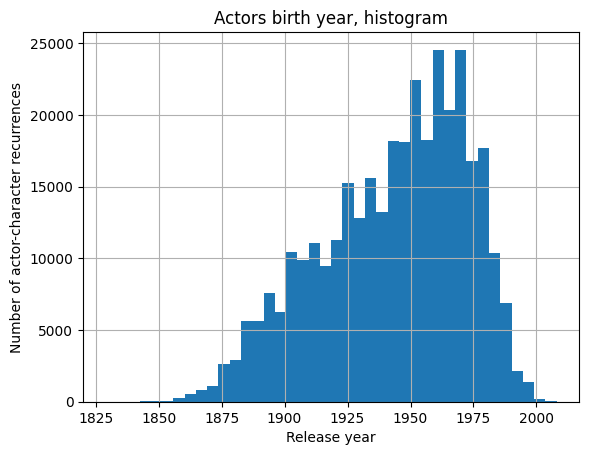

In [31]:
# actor birth year, histogram
# We dropped actors with a birth year <= 1828 or >= 2009, as we observed errors in the dataset
character_metadata[(character_metadata['actor_birth_year'] > 1828) * (character_metadata['actor_birth_year'] < 2009)].actor_birth_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors birth year, histogram');

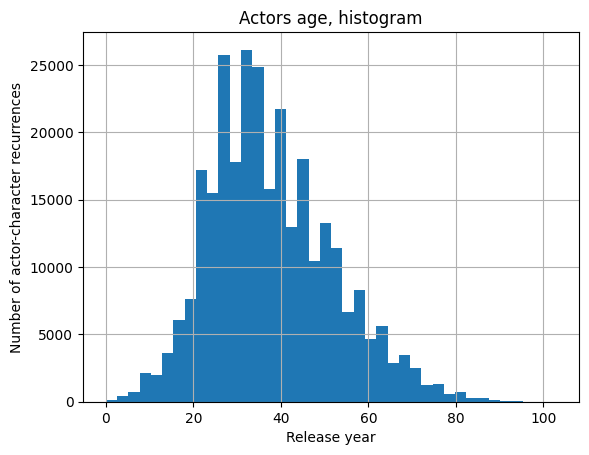

In [32]:
# actor age histogram
# We dropped actors with an age < 0, as we observed errors in the dataset
character_metadata[character_metadata['actor_age'] >= 0].actor_age.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors age, histogram');

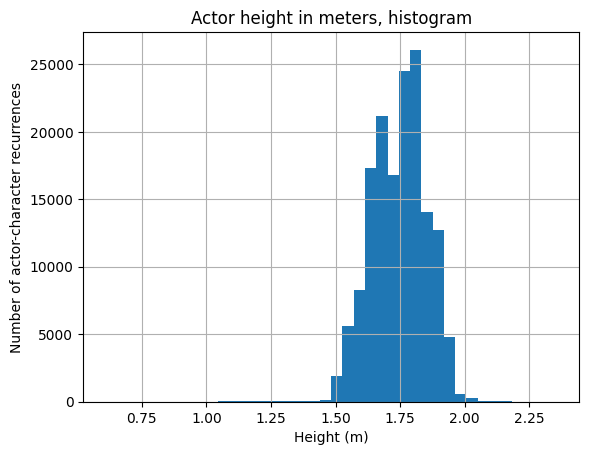

In [33]:
# actor height histogram
# We dropped actors with a height >= 3, as we observed errors in the dataset
character_metadata[character_metadata['actor_height'] < 3].actor_height.dropna().hist(bins = 40, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

# Plot evolution and similarity


In [34]:
from similarity_and_evolution import preprocess_text, cosine_similarity

plot_similarity = plot_summaries
plot_evolution = plot_summaries
plot_similarity['count_words'] = plot_similarity.apply(lambda x: len(str(x['plot']).split()), axis=1)

# Drop plots with less than 200 words
plot_similarity.drop(plot_similarity[plot_similarity['count_words'] < 200].index, inplace= True)

# Preprocess the synopses
# The Hunger Games
preprocessed_synopsis1 = preprocess_text(plot_similarity.query("wiki_movie_id == 31186339").iloc[0]['plot'])

# Fast and Furious: Tokyo Drift
preprocessed_synopsis2 = preprocess_text(plot_similarity.query("wiki_movie_id == 2913859").iloc[0]['plot'])

# Harry Potter: Deathly Hallows Part I
preprocessed_synopsis3 = preprocess_text(plot_similarity.query("wiki_movie_id == 9834441").iloc[0]['plot'])

# Mamma mia
preprocessed_synopsis4 = preprocess_text(plot_similarity.query("wiki_movie_id == 8425661").iloc[0]['plot'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxsebrechts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxsebrechts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maxsebrechts/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Compute cosine similarity between preprocessed plots

In [35]:
similarity_1 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis2)
similarity_2 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis3)
similarity_3 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis4)
similarity_4 = cosine_similarity(preprocessed_synopsis3, preprocessed_synopsis4)

### Cosine similarity interpretation and validation
If cosine similarity is equal to 1 means both plots are identical. On the other side, if cosine similarity is equal to 0 means the plots have nothing in common.

Overviewing the below similarities, it makes sense that "The Hunger Games" is more similar to a film such as "Harry Potter: Deathly Hallows Part 1" for more common actions such as "kill", "reveal" and "take" than to Fast&Furious and Mamma Mia. This actions may appear also in the latter movies but with less relevance.

And unusual phenomena is observed when comparing Harry Potter to Mamma Mia. Using the user's experience, one can argue these films are not very much alike. Investigating the issue further, we discover that this high value on similarity is due to one of the main protagonist for both films are called Harry.

Filtering people's name might be necessary to refine the algorithm.

In [36]:
print(f"Cosine Similarity The Hunger Games - F&F:Tokyo Drift: {similarity_1}")
print(f"Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: {similarity_2}")
print(f"Cosine Similarity The Hunger Games - Mamma mia: {similarity_3}")
print(f"Cosine Similarity HP: Death Hollows P1 - Mamma mia: {similarity_4}")

Cosine Similarity The Hunger Games - F&F:Tokyo Drift: 0.029112649379961022
Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: 0.0582765471839679
Cosine Similarity The Hunger Games - Mamma mia: 0.029958426421823198
Cosine Similarity HP: Death Hollows P1 - Mamma mia: 0.033301144786951474


### Similarity computation by year
We are interested on how much similar are movies released on the same year are alike

In [37]:
plot_similarity_enriched = pd.merge(plot_similarity, movie_metadata[['movie_name','release_year','wiki_movie_id']], on="wiki_movie_id",how='left')
plot_similarity_enriched.head()

,wiki_movie_id,plot,count_words,movie_name,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,778,The Hunger Games,2012.0
1,20663735,Poovalli Induchoodan is sentenced for six yea...,496,Narasimham,2000.0
2,2231378,"The Lemon Drop Kid , a New York City swindler,...",849,The Lemon Drop Kid,1951.0
3,595909,Seventh-day Adventist Church pastor Michael Ch...,397,A Cry in the Dark,1988.0
4,5272176,The president is on his way to give a speech. ...,344,End Game,2006.0


In [38]:
#similarity_by_year = plot_similarity_enriched.groupby('release_year')
#for year, group in similarity_by_year:
#    for idx, row in group.iterrows():
#        preprocessed_text = preprocess_text(row['plot'])
#        print(preprocessed_text)

### Emotional arc

An interesting aspect of a movie is its emotional arc. We give a sentiment value to each sentence in the plot summary and then interpret the sequence of sentiment values of the sentences as the movie's emotional arc.

In [50]:
from similarity_and_evolution import tokenize_per_sentence
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# The Hunger Games, tokenized per sentence
plot_per_sentence = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 31186339").iloc[0]['plot'])

In [52]:
analyzer = SentimentIntensityAnalyzer()
"""
    This function computes the sentiment value of each sentence in the plot, and returns all of them as a list.
"""
def compute_sentiment_sequence(plot_sentences):
    sentiment_sequence = []
    for sentence in plot_sentences:
        sentiment_sequence.append(analyzer.polarity_scores(sentence)['compound'])
    return sentiment_sequence

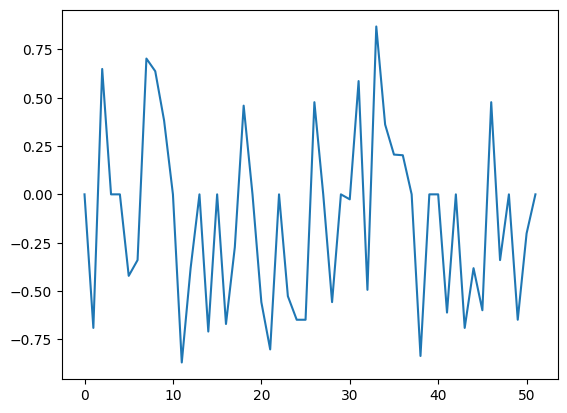

In [54]:
# plot the sentiment value sequence, i.e emotional arc, of the Hunger Games
plt.plot(compute_sentiment_sequence(plot_per_sentence))

## Regression ratings change over the years

In [40]:
# load dataset with imbd ids and movies metadata
imdb_rating_metadata = pd.read_csv('data/MovieSummaries/imdb_ratings_metadata.csv')
rating_revenue = imdb_rating_metadata.dropna(subset= ['box office revenue']).copy(deep=True)

In [41]:
imdb_ratings = pd.read_csv('data/MovieSummaries/imbd_ratings.csv')
imdb_ratings.rename( columns={'Unnamed: 0':'id'}, inplace=True )
ratings = imdb_ratings.loc[imdb_ratings.id.str.contains('ratings')].copy(deep=True)
ratings.id = ratings.id.str.replace('_ratings', '')
voters = imdb_ratings.loc[imdb_ratings.id.str.contains('_number_voters')].copy(deep=True)
voters.id = voters.id.str.replace('_number_voters', '')
rating_dif = ratings.second_date - ratings.first_date

In [42]:
rating_revenue = rating_revenue.merge(ratings,  left_on='tconst', right_on = 'id')

In [43]:
# extract values in dictionaries and release date
def get_first_value_from_dictionary(row, value):
    genres = list(json.loads(row[value]).values())[0]
    return genres

rating_revenue["genre"] = rating_revenue.apply(lambda row: get_first_value_from_dictionary(row, 'genres_x'), axis=1)
rating_revenue["language"] = rating_revenue.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
rating_revenue["country"] = rating_revenue.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
dates = rating_revenue['release date'].apply(lambda x : pd.to_datetime( x, format='%Y-%m-%d', errors='coerce')).copy(deep = True)
rating_revenue.loc[:,'release date'] = dates
rating_revenue['year'] = pd.DatetimeIndex(rating_revenue['release date']).year

In [44]:
# remove unnecessary columns
y = rating_revenue.first_date - rating_revenue.second_date
df_clean = rating_revenue.drop(['Unnamed: 0.1', 'Unnamed: 0', 'Wikipedia movie ID', 'Freebase movie ID',
       'name', 'release date', 'languages', 'isAdult', 
       'countries', 'genres_x', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'startYear', 'endYear', 'runtimeMinutes',
       'genres_y', 'first_date', 'second_date'], axis = 1).copy(deep = True)

In [45]:
# perform one hot encoding
one_hot = pd.get_dummies(df_clean[['genre', 'language', 'country']])
# Drop column B as it is now encoded
df = df_clean.drop(['genre', 'language', 'country'] ,axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [46]:
df = df.drop("id",axis=1)

In [47]:
# run linear regression to get the most relevant feature
X=(df-df.mean())/df.std()
X.fillna(0, inplace=True)

reg = LinearRegression().fit(X, y)
reg.coef_

array([-0.04015279, -0.02917308, -0.03904188, -0.01985451,  0.13073381,
        0.11535658, -0.04559599, -0.05237608, -0.16955912,  0.05693808,
        0.05884085,  0.04559549,  0.00485415, -0.02437255,  0.0597947 ,
       -0.0548901 ,  0.05884085, -0.0108824 , -0.01985451, -0.08396193,
        0.05884085,  0.0597947 ,  0.00847625])

In [48]:
# sorted coefficients
sorted(zip(reg.coef_,X.columns))

[(-0.16955911960406014, 'genre_Romantic comedy'),
 (-0.0839619318279588, 'country_Ireland'),
 (-0.05489009705351603, 'language_Portuguese Language'),
 (-0.05237607959586068, 'genre_Parody'),
 (-0.04559598652155595, 'genre_Drama'),
 (-0.040152792207018305, 'box office revenue'),
 (-0.03904187546520943, 'year'),
 (-0.029173084840056485, 'runtime'),
 (-0.02437254726170221, 'language_English Language'),
 (-0.01985450794298365, 'genre_Action/Adventure'),
 (-0.019854507942983542, 'country_Hong Kong'),
 (-0.010882402916353366, 'language_Standard Mandarin'),
 (0.004854150709093115, 'genre_Wuxia'),
 (0.00847624764789934, 'country_United States of America'),
 (0.04559548723368523, 'genre_Thriller'),
 (0.056938081432313596, 'genre_Science Fiction'),
 (0.058840852366657544, 'genre_Sports'),
 (0.05884085236665759, 'country_Mexico'),
 (0.05884085236665759, 'language_Spanish Language'),
 (0.05979469644415321, 'country_South Korea'),
 (0.05979469644415328, 'language_Korean Language'),
 (0.115356583719